# Arquivo para treinamento do modelo, inferencias e testes

In [74]:
import pandas as pd 
import numpy as np
from data_prepare import prepared_base

# Load data
base_hotel = prepared_base
base_hotel

,label_avg_price_per_room,no_of_adults,no_of_children,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,...,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,booking_status_Canceled,booking_status_Not_Canceled
0,0,2,0,0,224,2017,10,2,0,0,...,False,False,False,False,False,False,True,False,False,True
1,1,2,0,0,5,2018,11,6,0,0,...,False,False,False,False,False,False,False,True,False,True
2,0,1,0,0,1,2018,2,28,0,0,...,False,False,False,False,False,False,False,True,True,False
3,1,2,0,0,211,2018,5,20,0,0,...,False,False,False,False,False,False,False,True,True,False
4,1,2,0,0,48,2018,4,11,0,0,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2,3,0,0,85,2018,8,3,0,0,...,False,False,False,False,False,False,False,True,False,True
36271,1,2,0,0,228,2018,10,17,0,0,...,False,False,False,False,False,False,False,True,True,False
36272,1,2,0,0,148,2018,7,1,0,0,...,False,False,False,False,False,False,False,True,False,True
36273,1,2,0,0,63,2018,4,21,0,0,...,False,False,False,False,False,False,False,True,True,False


In [75]:
# substituir booleanos
base_hotel = base_hotel.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

In [76]:
base_train = base_hotel.iloc[0:28000,:]
base_test = base_hotel.iloc[28000:,:]

In [77]:
X_test = base_test.iloc[:,1:29].values
y_test = base_test.iloc[:, 0].values

In [78]:
print(base_train.shape)
print(base_test.shape)
print(X_test.shape)
print(y_test.shape)

(28000, 29)
(8275, 29)
(8275, 28)
(8275,)


In [79]:
base_train.to_csv('hotel_reservations_train_xgboost.csv', header = False, index = False)
base_test.to_csv('hotel_reservations_test_xgboost.csv', header = False, index = False)

# Configurações SageMaker

In [32]:
import os
from dotenv import load_dotenv

load_dotenv()

# Variaveis de ambiente
profile_name = os.getenv("PROFILE_NAME")
role_arn = os.getenv("ROLE_ARN")

In [49]:
import sagemaker
import boto3
from sagemaker import Session

# create and configure sessions
boto_session = boto3.Session(profile_name=profile_name)
boto3.setup_default_session(profile_name=profile_name)
session = sagemaker.Session(boto_session)
role = role_arn

# create bucket
bucket_name = "bucket-sprint5-compassuol"
s3_client = boto_session.client('s3')
try:
    response = s3_client.create_bucket(
        Bucket=bucket_name
    )
    print(f"Bucket '{bucket_name}' criado com sucesso.")
except s3_client.exceptions.BucketAlreadyOwnedByYou:
    print(f"O bucket '{bucket_name}' já existe e é de sua propriedade.")
except s3_client.exceptions.BucketAlreadyExists:
    print(f"O bucket '{bucket_name}' já existe, mas não é de sua propriedade.")
except Exception as e:
    print(f"Erro ao criar o bucket: {e}")

INFO:botocore.tokens:Loading cached SSO token for sessao


Bucket 'bucket-sprint5-compassuol' criado com sucesso.


In [50]:
subpasta_modelo = 'modelos/hotel-reservations/xgboost'
subpasta_dataset = 'datasets/hotel-reservations'
key_train = 'hotel-train-data-xgboost'
key_test = 'hotel-test-data-xgboost'

s3_train_data = 's3://{}/{}/train/{}'.format(bucket_name, subpasta_dataset, key_train)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket_name, subpasta_dataset, key_test)
output_location = 's3://{}/{}/output'.format(bucket_name, subpasta_modelo)

print(output_location)
print(role_arn)
print(profile_name)

s3://bucket-sprint5-compassuol/modelos/hotel-reservations/xgboost/output
arn:aws:iam::730335509042:role/service-role/AmazonSageMaker-ExecutionRole-20240702T161917
ester


In [51]:
import os
with open('hotel_reservations_train_xgboost.csv', 'rb') as f:
    s3_path = os.path.join(subpasta_dataset, 'train', key_train).replace('\\', '/')
    boto_session.resource('s3').Bucket(bucket_name).Object(s3_path).upload_fileobj(f)
    
print(s3_path)

datasets/hotel-reservations/train/hotel-train-data-xgboost


In [52]:
with open('hotel_reservations_test_xgboost.csv', 'rb') as f:
    s3_path = os.path.join(subpasta_dataset, 'test', key_test).replace('\\', '/')
    boto_session.resource('s3').Bucket(bucket_name).Object(s3_path).upload_fileobj(f)
    
print(s3_path)

datasets/hotel-reservations/test/hotel-test-data-xgboost


# Treinamento XGBoost

In [65]:
from sagemaker import image_uris
container = image_uris.retrieve(framework = 'xgboost', region=boto3.Session().region_name, version='1.7-1')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [66]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3, 
    'eval_metric': 'mlogloss',
    'gamma': '0.6307462738756113',
    'lambda': '0.13870950469471877',
    'colsample_bytree': '0.9580688142306052',
    'eta': '0.05375196116547447',
    'max_depth': '9',
    'min_child_weight': '2.629400053328948',
    'subsample': '0.9553898205800991',
    'num_round': 1000  
}

In [67]:
xgboost = sagemaker.estimator.Estimator(image_uri = container,
                                        role = role,
                                        instance_count = 1,
                                        instance_type = 'ml.m5.large',
                                        output_path = output_location,
                                        sagemaker_session = session,
                                        use_spot_instances = True,
                                        max_run = 3600,
                                        max_wait = 3600,
                                        hyperparameters=params)

In [68]:
train_input = sagemaker.inputs.TrainingInput(s3_data = s3_train_data, content_type='csv', s3_data_type = 'S3Prefix')
validation_input = sagemaker.inputs.TrainingInput(s3_data = s3_test_data, content_type='csv', s3_data_type = 'S3Prefix')
data_channels = {'train': train_input, 'validation': validation_input}

In [69]:
job = 'XGBoost-Sprint5'
xgboost.fit(data_channels, job_name=job)

INFO:sagemaker:Creating training-job with name: XGBoost-Sprint5


2024-07-13 23:50:09 Starting - Starting the training job...
2024-07-13 23:50:25 Starting - Preparing the instances for training...
2024-07-13 23:50:56 Downloading - Downloading input data...
2024-07-13 23:51:42 Downloading - Downloading the training image.........
2024-07-13 23:52:48 Training - Training image download completed. Training in progress..[2024-07-13 23:52:52.535 ip-10-0-115-37.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-07-13 23:52:52.556 ip-10-0-115-37.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-07-13:23:52:52:INFO] Imported framework sagemaker_xgboost_container.training
[2024-07-13:23:52:52:INFO] Failed to parse hyperparameter eval_metric value mlogloss to Json.
Returning the value itself
[2024-07-13:23:52:52:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2024-07-13:23:52:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-13:23:52

# Inferences

In [70]:
import xgboost as xgb


model_file_key = 'modelos/hotel-reservations/xgboost/output/XGBoost-Sprint5/output/model.tar.gz'
local_model_path = 'model.tar.gz'

s3 = boto3.client('s3')
s3.download_file(bucket_name, model_file_key, local_model_path)

In [71]:
import tarfile
with tarfile.open(local_model_path, 'r:gz') as tar:
    tar_list = tar.getnames()
    print("Files in the tar archive:", tar_list)
    
    # Extract all files
    tar.extractall()


model_file = 'xgboost-model'
if os.path.exists(model_file):
    with open(model_file, 'rb') as f:
        file_header = f.read(4)
        print("File header:", file_header)

Files in the tar archive: ['xgboost-model']
File header: b'binf'


In [72]:
model_file = 'xgboost-model'

# Load model
model = xgb.Booster()
model.load_model(model_file)

Acurácia: 86.13%
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      2548
           1       0.81      0.86      0.83      3158
           2       0.90      0.89      0.89      2569

    accuracy                           0.86      8275
   macro avg       0.87      0.86      0.86      8275
weighted avg       0.86      0.86      0.86      8275



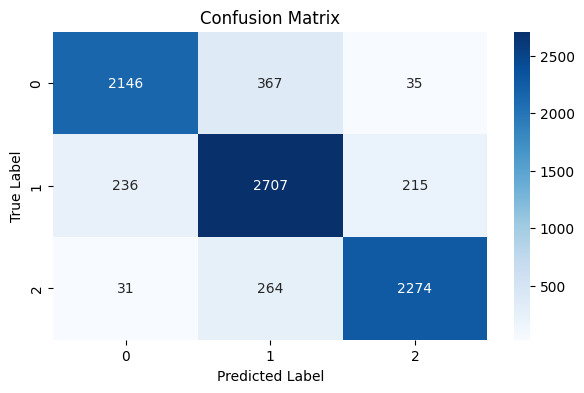

In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

dtest = xgb.DMatrix(X_test)
previsoes = model.predict(dtest)

# Arredondar previsões para o valor mais próximo
previsoes_rounded = np.round(previsoes).astype(int)

# Calcular e imprimir a acurácia
accuracy = accuracy_score(y_test, previsoes_rounded)
print(f'Acurácia: {accuracy * 100:.2f}%')

# Relatório de classificação
print(classification_report(y_test, previsoes_rounded))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, previsoes_rounded)
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()